In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.metrics import pairwise_distances
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import ConvexHull

import matplotlib

font = {"size": 30}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_points_near_line(slope, X, intercept=0):
    dists = np.abs(-slope * X[:, 0] + X[:, 1] - intercept) / np.sqrt(slope ** 2 + 1)
    observed_idx = np.where(dists <= slice_radius)[0]
    return observed_idx

In [3]:
np.random.seed(1)

# Create synthetic tissue
radius = 5
grid_size = 40
slice_radius = 0.25
n_experimental_iters = 10
noise_variance = 1e-1

limits = [-radius, radius]
x1s = np.linspace(*limits, num=grid_size)
x2s = np.linspace(*limits, num=grid_size)
X1, X2 = np.meshgrid(x1s, x2s)
X = np.vstack([X1.ravel(), X2.ravel()]).T
X += np.random.uniform(low=-0.5, high=0.5, size=X.shape)

# Filter by radius
norms = np.linalg.norm(X, ord=2, axis=1)
X = X[norms <= radius]


# Generate response
Y = mvn.rvs(mean=np.zeros(X.shape[0]), cov=Matern()(X) + noise_variance * np.eye(len(X)))

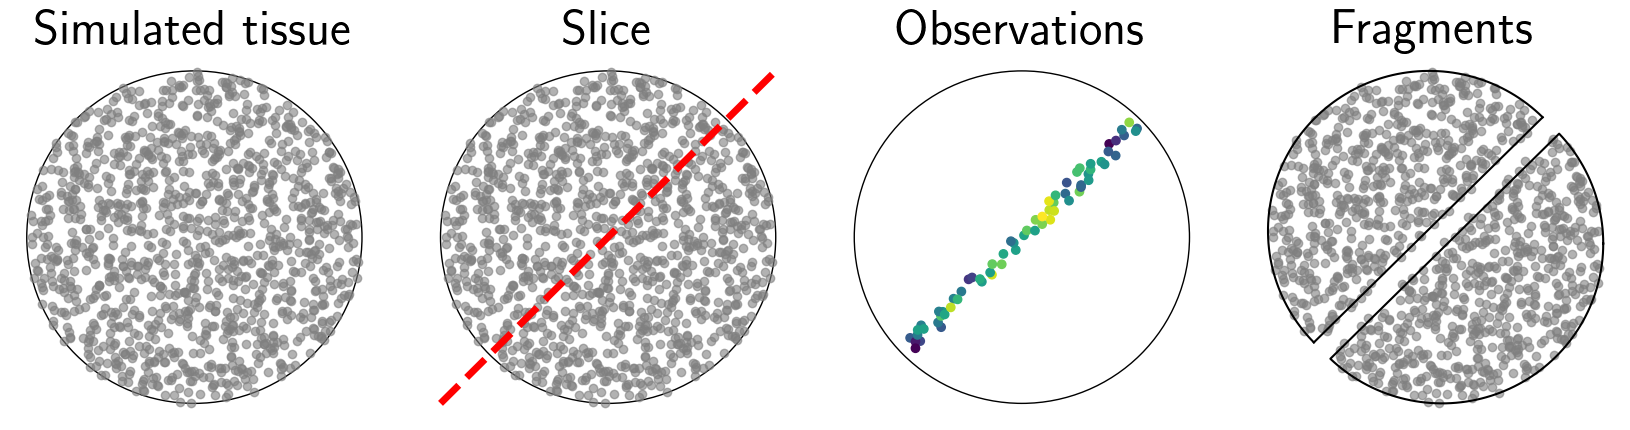

In [4]:

# Plot
plt.figure(figsize=(17, 5))
plt.subplot(141)
plt.title("Simulated tissue")
circle = plt.Circle((0, 0), radius, fill=False)
ax = plt.gca()
ax.add_patch(circle)
plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.6)
plt.xticks([])
plt.yticks([])
plt.axis("off")

plt.subplot(142)
slice_slope = 1.0
observed_idx = get_points_near_line(slope=slice_slope, X=X)

circle = plt.Circle((0, 0), radius, fill=False)
ax = plt.gca()
ax.add_patch(circle)
plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.6)
xs = np.linspace(-radius, radius, 200)
ys = slice_slope * xs
plt.plot(xs, ys, linestyle="--", color="red", linewidth=5)
plt.xticks([])
plt.yticks([])
plt.title("Slice")
plt.axis("off")

plt.subplot(143)
circle = plt.Circle((0, 0), radius, fill=False)
ax = plt.gca()
ax.add_patch(circle)
# plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.6)
plt.scatter(X[observed_idx, 0], X[observed_idx, 1], c=Y[observed_idx])
plt.xticks([])
plt.yticks([])
plt.title("Observations")
plt.axis("off")

plt.subplot(144)
angles = np.linspace(0, 2 * np.pi, 200)
xs = radius * np.cos(angles)
ys = radius * np.sin(angles)

above_idx = np.where(ys >= xs * slice_slope)[0]
below_idx = np.where(ys <= xs * slice_slope)[0]

xs_below = xs[below_idx] + 0.2
ys_below = ys[below_idx] - 0.2

xs_above = xs[above_idx] - 0.2
ys_above = ys[above_idx] + 0.2

plt.plot(xs_above, ys_above, color="black")
plt.plot(xs_above[np.array([0, -1])], ys_above[np.array([0, -1])], color="black")
plt.plot(xs_below, ys_below, color="black")

Xs_above = X[np.where(X[:, 1] > slice_slope * X[:, 0])[0]]
Xs_above[:, 0] -= 0.2
Xs_above[:, 1] += 0.2

Xs_below = X[np.where(X[:, 1] < slice_slope * X[:, 0])[0]]
Xs_below[:, 0] += 0.2
Xs_below[:, 1] -= 0.2


plt.scatter(Xs_above[:, 0], Xs_above[:, 1], color="gray", alpha=0.6)
plt.scatter(Xs_below[:, 0], Xs_below[:, 1], color="gray", alpha=0.6)
# plt.scatter(X[observed_idx, 0], X[observed_idx, 1], c=Y[observed_idx])
plt.xticks([])
plt.yticks([])
plt.title("Fragments")
plt.axis("off")
# import ipdb; ipdb.set_trace()

plt.tight_layout()
plt.savefig("./out/line_design_demo.png")

plt.show()
plt.close()

[1.20689655 1.47488966]
[3.62068966 1.17729101]
[-3.27586207  0.76018024]
[-0.17241379  1.17729101]
[-1.20689655  0.94725032]
[2.93103448 1.47488966]
[4.65517241 0.94725032]
[-4.65517241  0.76018024]
[-2.24137931  0.76018024]


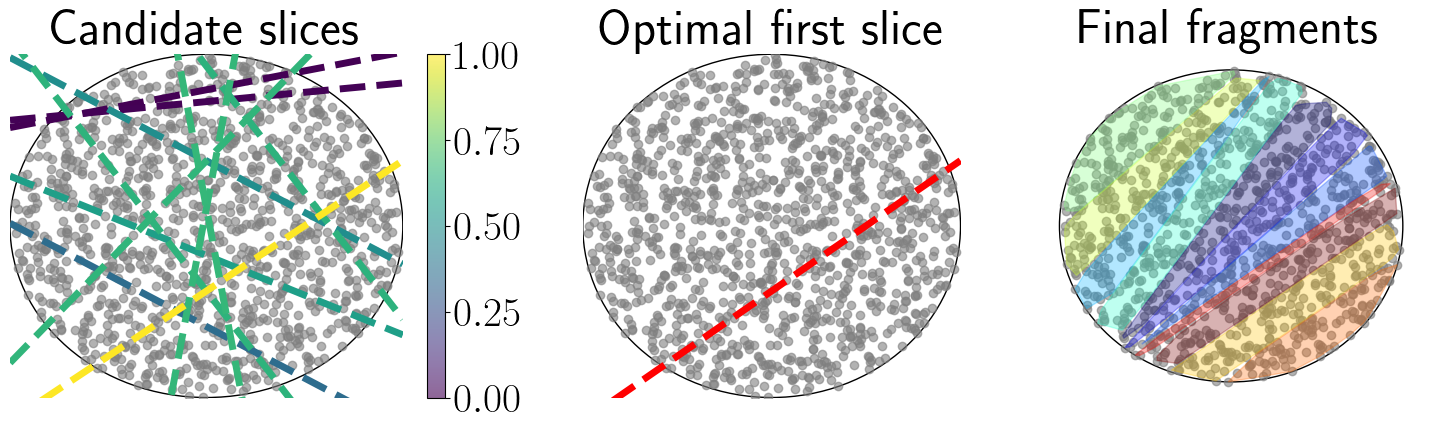

In [5]:

####### Run experiment #######

# Discretize design space
n_slope_discretizations = 30
n_intercept_discretizations = 30
slope_angles = np.linspace(0, np.pi, n_slope_discretizations)
slopes = np.tan(slope_angles)
intercepts = np.linspace(-radius, radius, n_intercept_discretizations)
designs1, designs2 = np.meshgrid(intercepts, slopes)
designs = np.vstack([designs1.ravel(), designs2.ravel()]).T
n_candidate_designs = len(designs)


# Run first iteration of experiment
# Here, it just depends on the GP prior

X_fragment_idx = []
best_designs = []

# kernel = Matern(length_scale_bounds="fixed") + WhiteKernel(noise_level=1e-3, noise_level_bounds="fixed")
kernel = Matern() + WhiteKernel()
eigs = np.zeros(n_candidate_designs)


for dd in range(n_candidate_designs):

    curr_design = designs[dd]
    curr_observed_idx = get_points_near_line(
        X=X, slope=curr_design[1], intercept=curr_design[0]
    )

    # Make predictions of expression
    cov = kernel(X[curr_observed_idx])

    # Compute EIG
    noise_variance = np.exp(kernel.k2.theta[0])
    eigs[dd] = (
        0.5
        * np.linalg.slogdet(1 / noise_variance * cov + np.eye(len(curr_observed_idx)))[
            1
        ]
    )

curr_best_design_idx = np.argmax(eigs)
curr_best_design = designs[curr_best_design_idx]

# idx_with_same_slope = np.where(designs[:, 1] == curr_best_design[1])[0]
idx_with_same_slope = np.random.choice(np.arange(len(designs)), replace=False, size=10)
idx_with_same_slope = np.append(idx_with_same_slope, curr_best_design_idx)
# idx_with_same_slope = np.where(designs[:, 1] == designs[:, 1][1000])[0]
logdets_with_same_slope = eigs[idx_with_same_slope]

# plt.figure(figsize=(10, 5))

fig, axs = plt.subplots(
    1, 3, figsize=(15, 5), gridspec_kw={"width_ratios": [1.3, 1, 1]}
)

# plt.subplot(121)
plt.sca(axs[0])
plt.title("Candidate slices")
circle = plt.Circle((0, 0), radius, fill=False)
ax = plt.gca()
ax.add_patch(circle)
plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.6)

# colors = plt.cm.jet(np.linspace(0, 1, len(idx_with_same_slope)))
logdets_with_same_slope_normalized = (
    logdets_with_same_slope - logdets_with_same_slope.min()
)
logdets_with_same_slope_normalized /= logdets_with_same_slope_normalized.max()
colors = plt.cm.viridis(logdets_with_same_slope_normalized)

for ii in np.argsort(logdets_with_same_slope):

    curr_intercept, curr_slope = designs[idx_with_same_slope[ii]]
    plt.plot(
        np.array([-radius, radius]),
        np.array(
            [
                curr_intercept + curr_slope * -radius,
                curr_intercept + curr_slope * radius,
            ]
        ),
        linewidth=5,
        linestyle="--",
        color=colors[ii],
    )

plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.colorbar()
plt.axis("off")

plt.sca(axs[1])
plt.title("Optimal first slice")
circle = plt.Circle((0, 0), radius, fill=False)
ax = plt.gca()
ax.add_patch(circle)
plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.6)

plt.plot(
    np.array([-radius, radius]),
    np.array(
        [
            curr_best_design[0] + curr_best_design[1] * -radius,
            curr_best_design[0] + curr_best_design[1] * radius,
        ]
    ),
    color="red",
    linewidth=5,
    linestyle="--",
)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xticks([])
plt.yticks([])
plt.axis("off")


best_designs.append(curr_best_design)
observed_idx = get_points_near_line(
    X=X, slope=curr_best_design[1], intercept=curr_best_design[0]
).tolist()


above_fragment_idx = np.where(
    X[:, 1] >= curr_best_design[0] + X[:, 0] * curr_best_design[1]
)[0]
below_fragment_idx = np.where(
    X[:, 1] <= curr_best_design[0] + X[:, 0] * curr_best_design[1]
)[0]
X_fragment_idx.append(above_fragment_idx)
X_fragment_idx.append(below_fragment_idx)

for iternum in range(1, n_experimental_iters):

    assert len(best_designs) == iternum
    assert len(X_fragment_idx) == iternum + 1

    # Fit GP on observed data
    gpr = GPR(kernel=kernel)
    gpr.fit(X[observed_idx], Y[observed_idx])

    # plt.close()
    # plt.scatter(X[:, 0], X[:, 1], c=gpr.predict(X, return_std=True)[1])
    # plt.show()

    best_eig = -np.inf
    best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

    for ff in range(len(X_fragment_idx)):

        # Get data for this fragment
        curr_X = X[X_fragment_idx[ff]]

        for dd in range(len(designs)):

            # Get points that would be observed by this slice
            curr_design = designs[dd]

            above_fragment_idx = np.where(
                curr_X[:, 1] >= curr_design[0] + curr_X[:, 0] * curr_design[1]
            )[0]
            if len(above_fragment_idx) in [
                0,
                1,
                2,
                len(curr_X),
                len(curr_X) - 1,
                len(curr_X) - 2,
            ]:
                continue

            curr_observed_idx = get_points_near_line(
                X=curr_X, slope=curr_design[1], intercept=curr_design[0]
            )
            if len(curr_observed_idx) == 0:
                continue

            _, cov = gpr.predict(curr_X[curr_observed_idx], return_cov=True)

            # Compute EIG for each slice through this fragment
            noise_variance = np.exp(gpr.kernel_.k2.theta[0])
            curr_eig = (
                0.5
                * np.linalg.slogdet(
                    1 / noise_variance * cov + np.eye(len(curr_observed_idx))
                )[1]
            )

            if curr_eig > best_eig:
                best_design_idx = dd
                best_fragment_idx = ff
                best_observed_idx = X_fragment_idx[ff][curr_observed_idx]
                best_eig = curr_eig

    curr_best_design = designs[best_design_idx]
    print(curr_best_design)
    best_fragment_X = X[X_fragment_idx[best_fragment_idx]]
    # import ipdb

    # ipdb.set_trace()

    above_fragment_idx = np.where(
        best_fragment_X[:, 1]
        >= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
    )[0]
    below_fragment_idx = np.where(
        best_fragment_X[:, 1]
        <= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
    )[0]

    above_idx = X_fragment_idx[best_fragment_idx][above_fragment_idx]
    below_idx = X_fragment_idx[best_fragment_idx][below_fragment_idx]
    X_fragment_idx.pop(best_fragment_idx)
    X_fragment_idx.append(above_idx)
    X_fragment_idx.append(below_idx)

    best_designs.append(curr_best_design)
    observed_idx.extend(best_observed_idx)

    # plt.close()
    # plt.figure(figsize=(5, 5))
    # circle = plt.Circle((0, 0), radius, fill=False)
    # ax = plt.gca()
    # ax.add_patch(circle)
    # plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.6)
    # plt.scatter(best_fragment_X[:, 0], best_fragment_X[:, 1], color="red", alpha=0.6)

    # plt.plot(
    #     np.array([-radius, radius]),
    #     np.array([curr_best_design[0] + curr_best_design[1] * -radius, curr_best_design[0] + curr_best_design[1] * radius])
    # )
    # plt.xlim([-5, 5])
    # plt.ylim([-5, 5])
    # plt.show()


# Plot Voronoi diagram

plt.sca(axs[2])
plt.title("Final fragments")
circle = plt.Circle((0, 0), radius, fill=False)
ax = plt.gca()
ax.add_patch(circle)
plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.6)

# for ii in range(n_experimental_iters):
#     curr_design = best_designs[ii]
#     plt.plot(
#         np.array([-radius, radius]),
#         np.array([curr_design[0] + curr_design[1] * -radius, curr_design[0] + curr_design[1] * radius])
#     )
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])
# plt.show()
patches = []
colors = plt.cm.jet(np.linspace(0, 1, n_experimental_iters + 1))
for ii in range(n_experimental_iters + 1):

    curr_X = X[X_fragment_idx[ii]]

    hull = ConvexHull(curr_X)

    polygon = Polygon(curr_X[hull.vertices], True)
    patches.append(polygon)

    plt.fill(
        curr_X[hull.vertices, 0],
        curr_X[hull.vertices, 1],
#         "k",
        alpha=0.3,
        color=colors[ii],
    )


# plt.figure(figsize=(5, 5))
# p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
# colors = np.linspace(0, 100, len(patches))
# p.set_array(np.array(colors))
# ax = plt.gca()
# ax.add_collection(p)
plt.axis("off")

plt.tight_layout()
plt.savefig("./out/simulated_slicing_experiment.png")
plt.show()

In [6]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')


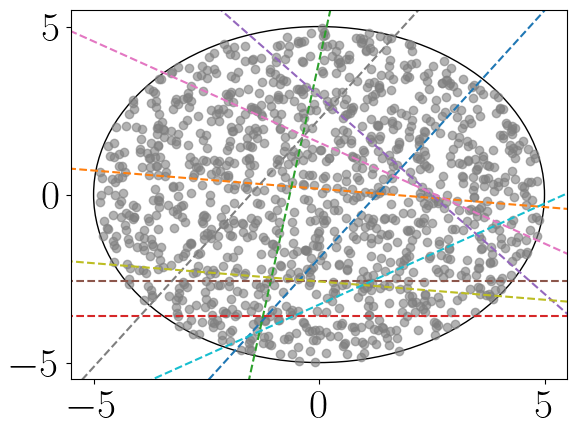

In [7]:
circle = plt.Circle((0, 0), radius, fill=False)
ax = plt.gca()
ax.add_patch(circle)
plt.scatter(X[:, 0], X[:, 1], color="gray", alpha=0.6)
# plt.xticks([])
# plt.yticks([])
# plt.axis("off")

xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()

for dd in np.random.choice(np.arange(len(designs)), size=10, replace=False):
    abline(designs[dd][1], designs[dd][0])

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()